In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

In [2]:
wine_cols = ['Class', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of ash ', 'Magnesium',
                 'Total phenols', 'Flavanoids' , 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wine = pd.read_csv("D:/deu data science YL/2.donem/denetimsiz/tsne/wine.data", names=wine_cols)

wine.head()

,Class,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Etiketlerin ve özelliklerin (1,2,3 şarap kalitesi) ayrılması.
feats = wine.drop("Class", axis=1)
label = wine["Class"]

In [4]:
# Standardizasyon
standardized_data = StandardScaler().fit_transform(feats)

In [5]:
# t-SNE
# Perform t-SNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(standardized_data)

# Create a DataFrame with the t-SNE results and labels
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

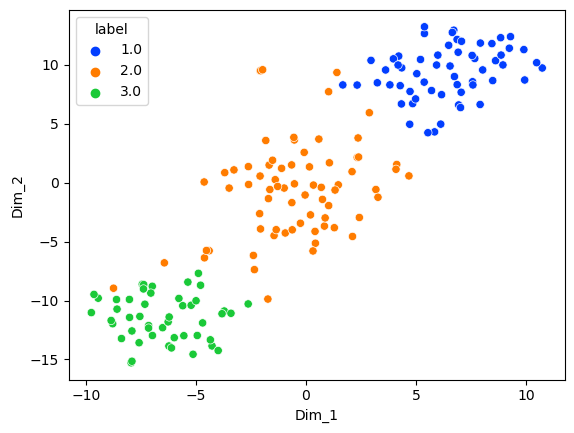

In [6]:
# Grafik
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.show()

In [7]:
# Perform KMeans clustering on t-SNE data
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# Determine the optimal number of clusters using the elbow method for t-SNE
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tsne_df[['Dim_1', 'Dim_2']])
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_k = kl.elbow
print(f"The optimal number of clusters for t-SNE is {optimal_k}")

The optimal number of clusters for t-SNE is 3


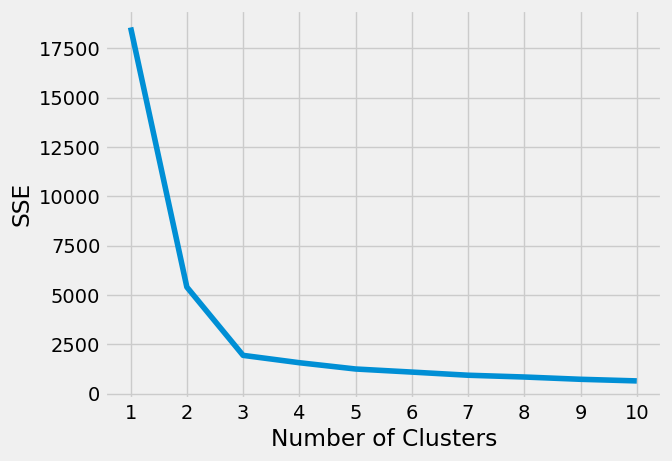

In [8]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# Elbow
sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(tsne_df)
     sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [9]:
# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, **kmeans_kwargs)
kmeans.fit(tsne_df[['Dim_1', 'Dim_2']])

# Add the cluster assignments to the dataset
tsne_df['Cluster'] = kmeans.labels_



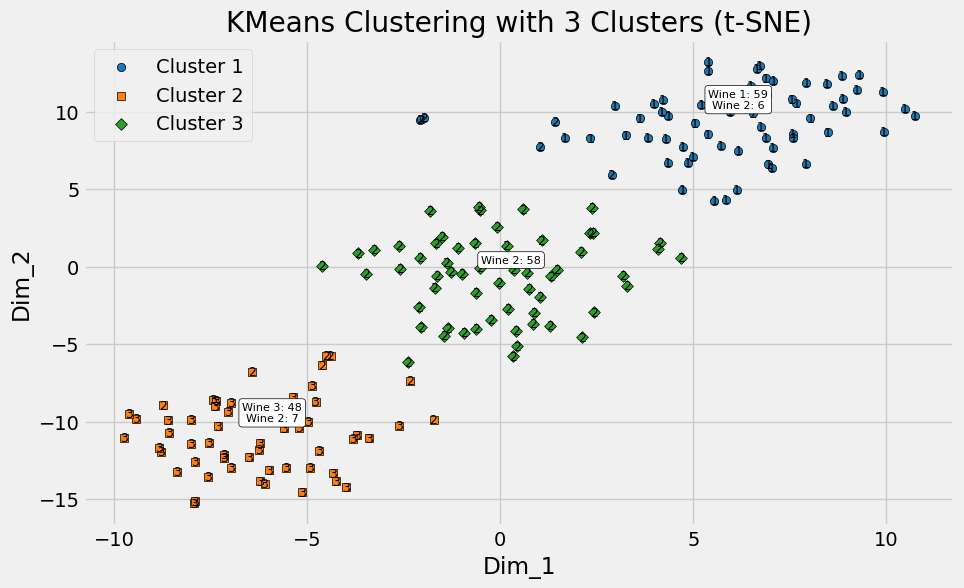

In [10]:
# Plot the clusters using Matplotlib for t-SNE
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', 'D']

for i in range(optimal_k):
    cluster_data = tsne_df[tsne_df['Cluster'] == i]
    plt.scatter(cluster_data['Dim_1'], cluster_data['Dim_2'], 
                color=colors[i], marker=markers[i], 
                label=f'Cluster {i + 1}', edgecolor='k')

# Add the labels for t-SNE
for i in range(len(tsne_df)):
    plt.text(tsne_df['Dim_1'][i], tsne_df['Dim_2'][i], str(int(tsne_df['label'][i])), 
             fontsize=9, ha='center', va='center')

# Add a summary of wine types in each cluster for t-SNE
for cluster in range(optimal_k):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    wine_types = cluster_data['label'].value_counts().to_dict()
    summary_text = "\n".join([f'Wine {int(k)}: {int(v)}' for k, v in wine_types.items()])
    plt.annotate(summary_text, (cluster_data['Dim_1'].mean(), cluster_data['Dim_2'].mean()), 
                 textcoords="offset points", xytext=(10,10), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Set the title and labels for t-SNE
plt.title(f"KMeans Clustering with {optimal_k} Clusters (t-SNE)")
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Create a summary of wine classes within each cluster for t-SNE
tsne_cluster_summary = tsne_df.groupby('Cluster')['label'].value_counts().unstack().fillna(0)
print("t-SNE Cluster Summary:")
print(tsne_cluster_summary)
print(" ")
silhouette_avg_tsne = silhouette_score(tsne_df[["Dim_1", "Dim_2"]], tsne_df['Cluster'])
print(f"The silhouette score for {optimal_k} clusters tSNE is {silhouette_avg_tsne:.2f}")

t-SNE Cluster Summary:
label     1.0   2.0   3.0
Cluster                  
0        59.0   6.0   0.0
1         0.0   7.0  48.0
2         0.0  58.0   0.0
 
The silhouette score for 3 clusters tSNE is 0.62


In [12]:
#### PCA İLE KARŞILAŞTIRMA
wine_cols = ['Class', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of ash ', 'Magnesium',
                 'Total phenols', 'Flavanoids' , 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wine = pd.read_csv("D:/deu data science YL/2.donem/denetimsiz/tsne/wine.data", names=wine_cols)

wine.head()

,Class,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [13]:
# Etiketlerin ve özelliklerin (1,2,3 şarap kalitesi) ayrılması.
feats = wine.drop("Class", axis=1)
label = wine["Class"]

(178, 14)
Eigenvalues: [5.56722458 2.51118402 1.45424413 0.9331603  0.88246016 0.67657935
 0.55692777 0.35201176 0.29620602 0.26378805 0.2271244  0.16975037
 0.13029618 0.05813894]


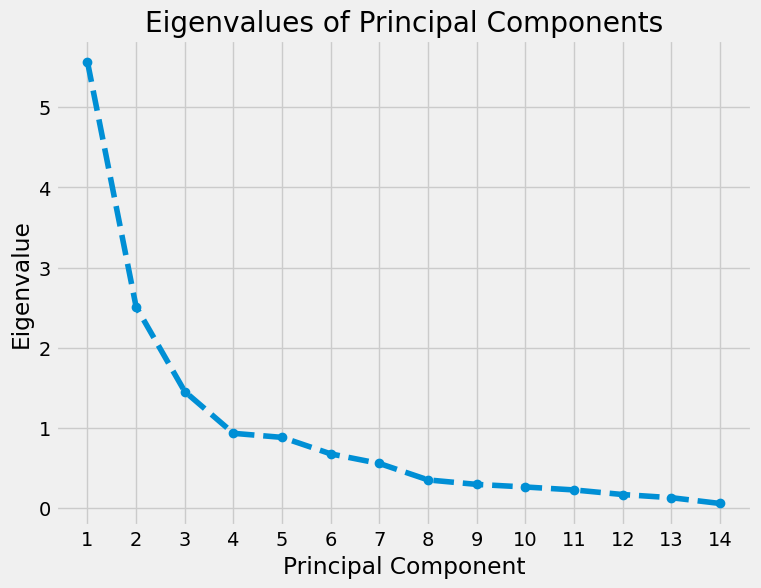

In [14]:
# Standardizasyon
standardized_data = StandardScaler().fit_transform(wine)
print(standardized_data.shape)

pca = PCA()

pca_data = pca.fit_transform(standardized_data)

# Eigenvalues (özdeğerler) hesaplanması
eigenvalues = pca.explained_variance_
print(f"Eigenvalues: {eigenvalues}")

# Eigenvalues (özdeğerler) grafiği
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()

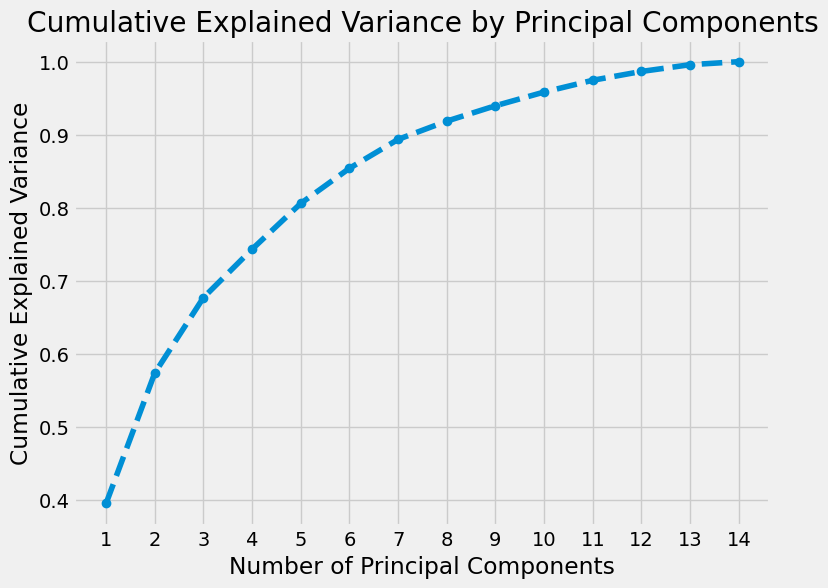

In [15]:
# Cumulative explained variance (kümülatif açıklanan varyans) grafiği
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

In [16]:
# Create a DataFrame with the PCA results and labels
# PCA Analysis
pca = PCA(n_components=3)
pca_data = pca.fit_transform(standardized_data)

# Create a DataFrame with the PCA results and labels
pca_data = np.vstack((pca_data.T, label.to_numpy())).T
pca_df = pd.DataFrame(data=pca_data, columns=("PC1", "PC2", "PC3", "label"))


In [17]:
# Determine the optimal number of clusters using the elbow method for PCA
sse_pca = []
for k in range(1, 11):
    kmeans_pca = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_pca.fit(pca_df[['PC1', 'PC2', 'PC3']])
    sse_pca.append(kmeans_pca.inertia_)

kl_pca = KneeLocator(range(1, 11), sse_pca, curve="convex", direction="decreasing")
optimal_k_pca = kl_pca.elbow
print(" ")
print(f"The optimal number of clusters for PCA is {optimal_k_pca}")


 
The optimal number of clusters for PCA is 3


In [18]:
# Fit KMeans with the optimal number of clusters for PCA
kmeans_pca = KMeans(n_clusters=optimal_k_pca, **kmeans_kwargs)
kmeans_pca.fit(pca_df[['PC1', 'PC2', 'PC3']])

# Add the cluster assignments to the dataset for PCA
pca_df['Cluster'] = kmeans_pca.labels_

# Create a summary of wine classes within each cluster for PCA
pca_cluster_summary = pca_df.groupby('Cluster')['label'].value_counts().unstack().fillna(0)
print("PCA Cluster Summary:")
print(pca_cluster_summary)

PCA Cluster Summary:
label     1.0   2.0   3.0
Cluster                  
0        59.0   3.0   0.0
1         0.0   1.0  48.0
2         0.0  67.0   0.0


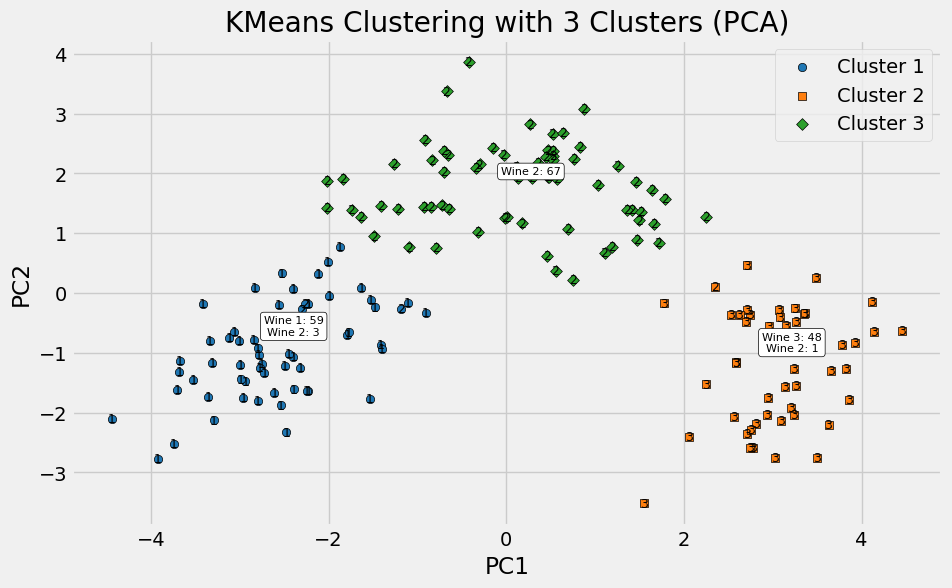

In [19]:
# Plot the clusters using Matplotlib for PCA (first two components)
plt.figure(figsize=(10, 6))

for i in range(optimal_k_pca):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                color=colors[i], marker=markers[i], 
                label=f'Cluster {i + 1}', edgecolor='k')

# Add the labels for PCA
for i in range(len(pca_df)):
    plt.text(pca_df['PC1'][i], pca_df['PC2'][i], str(int(pca_df['label'][i])), 
             fontsize=9, ha='center', va='center')

# Add a summary of wine types in each cluster for PCA
for cluster in range(optimal_k_pca):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    wine_types = cluster_data['label'].value_counts().to_dict()
    summary_text = "\n".join([f'Wine {int(k)}: {int(v)}' for k, v in wine_types.items()])
    plt.annotate(summary_text, (cluster_data['PC1'].mean(), cluster_data['PC2'].mean()), 
                 textcoords="offset points", xytext=(10,10), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Set the title and labels for PCA
plt.title(f"KMeans Clustering with {optimal_k_pca} Clusters (PCA)")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate the silhouette score for PCA
silhouette_avg_pca = silhouette_score(pca_df[['PC1', 'PC2', 'PC3']], pca_df['Cluster'])
print(f"The silhouette score for {optimal_k_pca} clusters (PCA) is {silhouette_avg_pca:.2f}")

The silhouette score for 3 clusters (PCA) is 0.49
